In [1]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

/Users/parth/Downloads/Applied-Advanced-RAG/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
loader = DirectoryLoader('./', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

In [3]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [4]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vectors = embeddings.embed_documents(doc_strings)

In [5]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 6})

In [6]:
import umap
import numpy as np
from tqdm import tqdm

umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors)

/Users/parth/Downloads/Applied-Advanced-RAG/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [7]:
def umap_embed(vectors, umap_transformer):
    umap_embeddings = np.array([umap_transformer.transform([vector])[0] for vector in tqdm(vectors)])
    return umap_embeddings

In [8]:
global_embeddings = umap_embed(vectors, umap_transformer)

100%|██████████| 65/65 [01:10<00:00,  1.09s/it]


In [9]:
global_embeddings

array([[ 8.743237 , 10.439878 ],
       [ 8.497601 ,  9.374089 ],
       [ 4.9308043, 11.108779 ],
       [ 6.92887  ,  9.540767 ],
       [ 5.951041 , 12.4415   ],
       [ 8.129782 , 10.613178 ],
       [ 6.800109 , 11.937155 ],
       [ 5.520897 , 11.030716 ],
       [ 7.118406 ,  9.634922 ],
       [ 6.9391446, 11.927634 ],
       [ 7.075708 , 11.884147 ],
       [ 6.806058 ,  9.637219 ],
       [ 5.619075 , 12.651238 ],
       [ 8.29362  , 11.122522 ],
       [ 7.4781833, 11.979335 ],
       [ 8.231965 , 11.074107 ],
       [ 6.1531672, 12.23069  ],
       [ 6.921373 , 11.922654 ],
       [ 7.093704 , 11.920173 ],
       [ 7.3585916,  9.698845 ],
       [ 8.183302 , 10.526764 ],
       [ 4.520167 , 11.941232 ],
       [ 7.6425776, 12.117426 ],
       [ 8.321631 , 11.375393 ],
       [ 5.0556536, 11.010754 ],
       [ 8.263013 , 11.058572 ],
       [ 4.5998263, 11.461556 ],
       [ 5.858043 , 10.306568 ],
       [ 6.566521 ,  9.548009 ],
       [ 5.124354 , 10.981807 ],
       [ 5

Matplotlib is building the font cache; this may take a moment.


(4.132861065864563, 12.653588843345641, 5.586129307746887, 12.987672209739685)

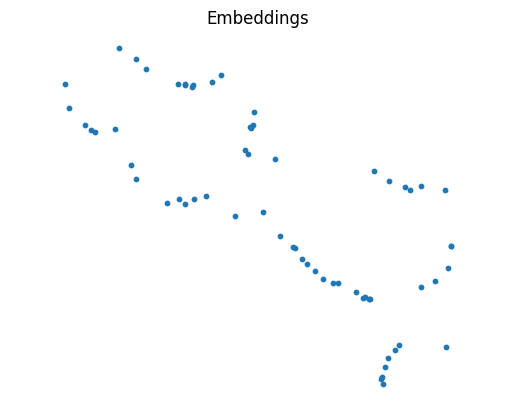

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings')
plt.axis('off')

In [12]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    page_contents = [doc.page_content for doc in docs]
    vectors_content_vectors = embeddings.embed_documents(page_contents)

    query_embeddings = embed_function([q_embedding], umap_transformer)
    retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

    plt.figure()
    plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='gray')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='X', color='r')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()


/Users/parth/Downloads/Applied-Advanced-RAG/venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(
100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


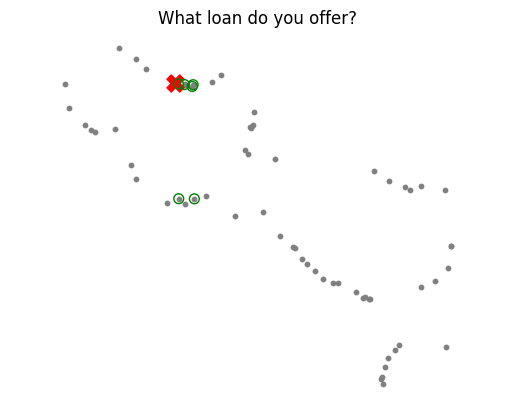

In [13]:
calc_global_embeddings("What loan do you offer?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


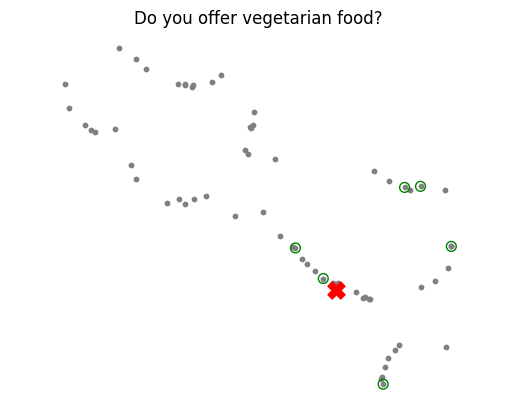

In [14]:
calc_global_embeddings("Do you offer vegetarian food?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)


### Query Expansion 

In [23]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [ ]:
from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field

query = "Do you offer vegetarian food?"

class LineList(BaseModel):
    lines: list[str] = Field(description="Lines of text")


class LineListOutputParser(PydanticOutputParser):
    def __init__(self) -> None:
        super().__init__(pydantic_object=LineList)

    def parse(self, text: str) -> list[str]:
        lines = text.strip().split("\n")
        return lines


output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. Only provide the query, no numbering.
    Original question: {question}""",
)

llm_chain = QUERY_PROMPT|llm|output_parser
queries = llm_chain.invoke(query)

In [24]:
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

query = "Do you offer vegetarian food?"

output_parser = StrOutputParser()

QUERY_PROMPT = ChatPromptTemplate.from_messages(
     [
    (
        "system",
        """You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. Only provide the query, no numbering.
    Original question: {question}""",
    ),
    ("human", "{question}"),
]
)




In [26]:
queries

'What vegetarian options are available?\nIs there a vegetarian menu?\nCan I get food without meat?\nWhat dishes are meat-free?\nDo you cater to vegetarian diets? \n'

In [25]:
queries = queries.get("text")
queries

AttributeError: 'str' object has no attribute 'get'

In [ ]:
docs = [retriever.get_relevant_documents(query) for query in queries]

In [ ]:
unique_contents = set()
unique_docs = []
for sublist in docs:
    for doc in sublist:
        if doc.page_content not in unique_contents:
            unique_docs.append(doc)
            unique_contents.add(doc.page_content)
unique_contents = list(unique_contents)

In [ ]:
unique_contents

# Cross-encoder re-ranking

In [ ]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
pairs = []
for doc in unique_contents:
    pairs.append([query, doc])

In [ ]:
scores = cross_encoder.predict(pairs)
scores

In [ ]:
scored_docs = zip(scores, unique_contents)
sorted_docs = sorted(scored_docs, reverse=True)
sorted_docs

In [ ]:
reranked_docs = [doc for _, doc in sorted_docs][0:8]
reranked_docs

### Lost in the middle Problem

In [ ]:
from langchain_community.document_transformers import (
    LongContextReorder
)

In [ ]:
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(reranked_docs)
reordered_docs